In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
df = pd.read_csv("../../results/aggregated.csv")
df["hostname"] = [hostname.strip() for hostname in df["hostname"]]
hostnames = set(df["hostname"].values)
benchmarks = set(df["benchmark"].values)
colors = list(mcolors.TABLEAU_COLORS.keys())

In [3]:
supercomputers = ["wheeler282.alliance.unm.edu", "xena-test.xena.alliance.unm.edu"]
clock_speeds = {
    "xena-test.xena.alliance.unm.edu": 2.60,
    "yucca": 2.4,
    "leda": 3.6,
    "Aureolin": 2.688,
    "wheeler282.alliance.unm.edu": 2.67,
    "Celeste": 3.2,
    "ocotillo": 2.4,
    "mack": 3.5,
    "sahu": 2.0,
}
num_cores = {
    "xena-test.xena.alliance.unm.edu": 16,
    "yucca": 16,
    "leda": 16,
    "Aureolin": 10,
    "wheeler282.alliance.unm.edu": 8,
    "Celeste": 6,
    "ocotillo": 4,
    "mack": 4,
    "sahu": 128,
}
df["clock_speed"] = [clock_speeds[hostname] for hostname in df["hostname"]]
df["num_cores"] = [num_cores[hostname] for hostname in df["hostname"]]
df["norm"] = df["avg_time"] * df["clock_speed"]
df["norm_std"] = df["std_dev"] * np.sqrt(df["clock_speed"])
df["scaled"] = df["avg_time"] * df["num_cores"] / df["num_procs"]
df["scaled_std"] = df["avg_time"] * np.sqrt(df["num_cores"] / df["num_procs"])
df["super"] = [1 if hostname in supercomputers else 0 for hostname in df["hostname"]]

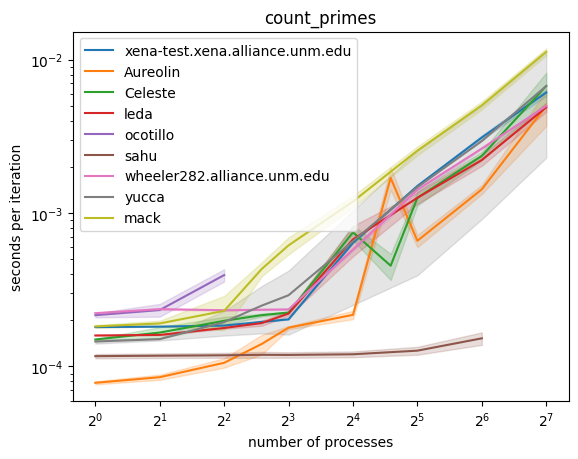

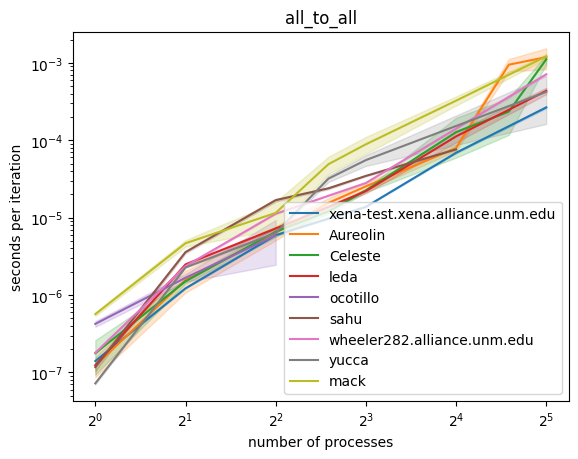

In [5]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark)
    bench_df = df[df["benchmark"] == benchmark]
    for i, hostname in enumerate(hostnames):
        series = bench_df[bench_df["hostname"] == hostname]
        avg = series.groupby("num_procs", as_index=False)["avg_time"].mean()
        std = series.groupby("num_procs", as_index=False)["std_dev"].mean()
        nprocs = avg["num_procs"]
        avg = avg["avg_time"]
        std = std["std_dev"]
        
        ax.fill_between(nprocs, avg + std, avg - std, alpha=0.2, color=colors[i])
        ax.plot(nprocs, avg, label=hostname, color=colors[i])
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("number of processes")
    ax.set_ylabel("seconds per iteration")
    plt.savefig(benchmark + ".pdf", bbox_inches="tight")
    plt.show()

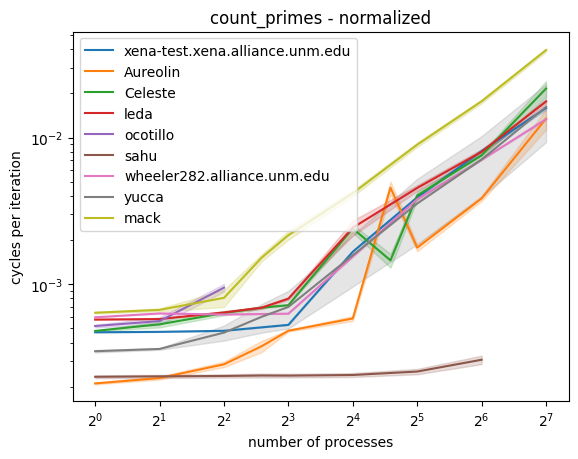

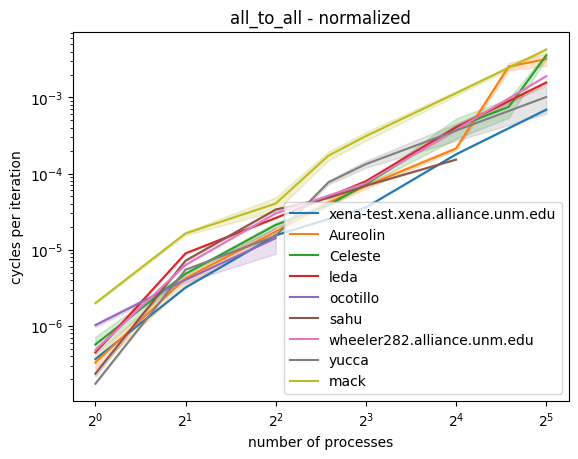

In [6]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark + " - normalized")
    bench_df = df[df["benchmark"] == benchmark]
    for i, hostname in enumerate(hostnames):
        series = bench_df[bench_df["hostname"] == hostname]
        avg = series.groupby("num_procs", as_index=False)["norm"].mean()
        std = series.groupby("num_procs", as_index=False)["norm_std"].mean()
        nprocs = avg["num_procs"]
        avg = avg["norm"]
        std = std["norm_std"]
        
        ax.fill_between(nprocs, avg + std, avg - std, alpha=0.2, color=colors[i])
        ax.plot(nprocs, avg, label=hostname, color=colors[i])
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("number of processes")
    ax.set_ylabel("cycles per iteration")
    plt.savefig(benchmark + "_normalized.pdf", bbox_inches="tight")
    plt.show()

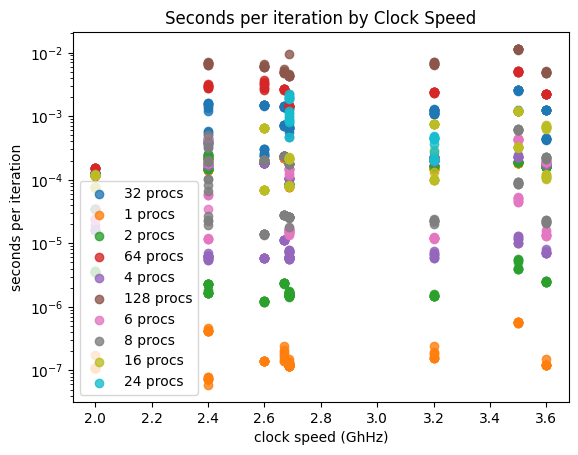

In [13]:
fig, ax = plt.subplots()
for num_procs in set(df["num_procs"].values):
    subdf = df[df["num_procs"] == num_procs]
    ax.scatter(subdf["clock_speed"], subdf["avg_time"], label=f"{num_procs} procs", alpha=0.8)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("clock speed (GhHz)")
ax.set_ylabel("seconds per iteration")
ax.set_title("Seconds per iteration by Clock Speed")
plt.savefig("correlation.pdf", bbox_inches="tight")
plt.show()

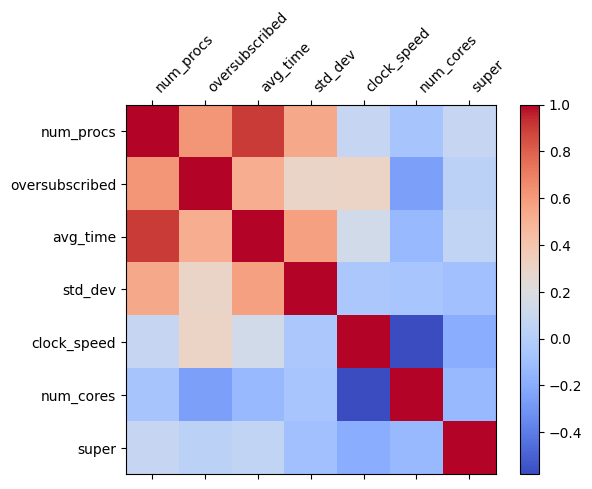

,num_procs,oversubscribed,avg_time,std_dev,clock_speed,num_cores,super
num_procs,1.000000,0.611987,0.905435,0.543137,0.077284,-0.061815,0.080509
oversubscribed,0.611987,1.000000,0.522124,0.300347,0.303859,-0.252996,0.036190
avg_time,0.905435,0.522124,1.000000,0.576741,0.143598,-0.131945,0.057964
std_dev,0.543137,0.300347,0.576741,1.000000,-0.044186,-0.061203,-0.088039
clock_speed,0.077284,0.303859,0.143598,-0.044186,1.000000,-0.579561,-0.191922
num_cores,-0.061815,-0.252996,-0.131945,-0.061203,-0.579561,1.000000,-0.131001
super,0.080509,0.036190,0.057964,-0.088039,-0.191922,-0.131001,1.000000


In [14]:
fig, ax = plt.subplots()
corr = df[["num_procs", "oversubscribed", "avg_time", "std_dev", "clock_speed", "num_cores", "super"]].corr()
corr.style.background_gradient(cmap="coolwarm")
col = ax.matshow(corr, cmap="coolwarm")
fig.colorbar(col)

labels = corr.columns.values
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="left")
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
plt.show()

corr.style.background_gradient(cmap="coolwarm")

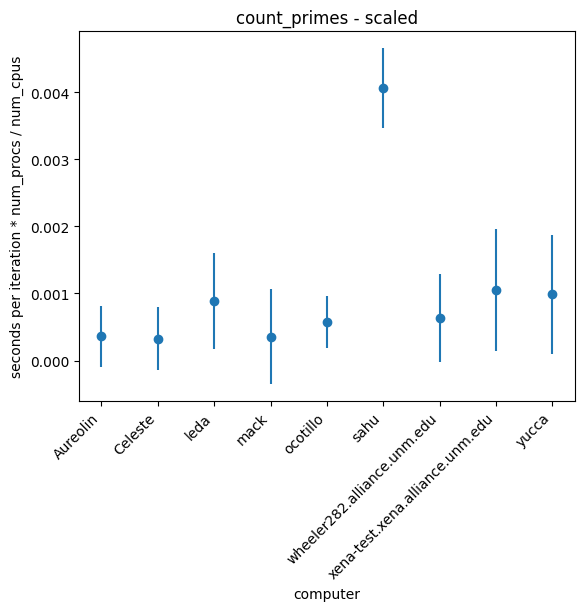

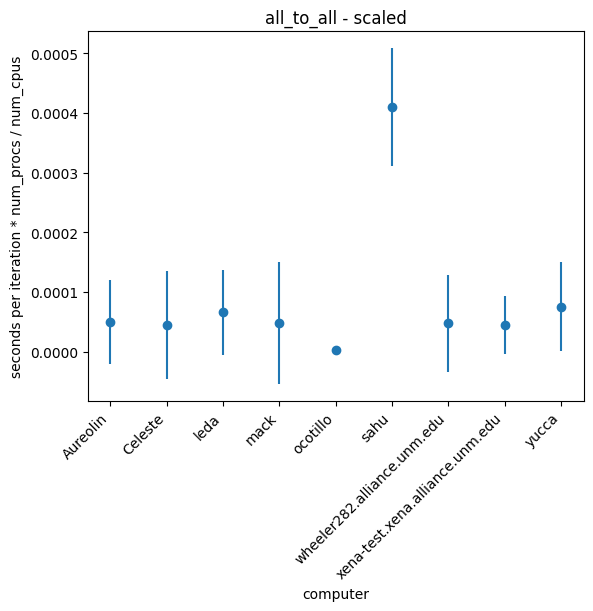

In [15]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark + " - scaled")
    bench_df = df[df["benchmark"] == benchmark]
    avg = bench_df.groupby("hostname", as_index=False)["scaled"].mean()
    std = bench_df.groupby("hostname", as_index=False)["scaled_std"].mean()
    hostname = avg["hostname"]
    avg = avg["scaled"]
    std = std["scaled_std"]

    ax.errorbar(hostname, avg, yerr=std, marker='o', linestyle='none')
    
    ax.set_xlabel("computer")
    ax.set_ylabel("seconds per iteration * num_procs / num_cpus")
    ax.set_xticks(np.arange(len(hostname)))
    ax.set_xticklabels(hostname, rotation=45, ha="right")
    plt.savefig(benchmark + "_scaled.pdf", bbox_inches="tight")
    plt.show()